# Metadata

```
Course:   DS 5001
Module:   04 Lab
Topic:    NLP and the Pipeline
Author:   R.C. Alvarado

Purpose:  We import a collection of texts and convert to F2. Then we annotate the collection to create an F3-level model.
```

# Set Up

In [1]:
data_home = "../data"
local_lib = "../lib"
source_files = f'{data_home}/gutenberg/austen-melville-set'
data_prefix = 'austen-melville'

In [2]:
OHCO = ['book_id', 'chap_num', 'para_num', 'sent_num', 'token_num']

In [122]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import seaborn as sns; sns.set()
import plotly_express as px

In [4]:
import sys
sys.path.append(local_lib)

In [5]:
from textparser import TextParser

# Inspect

Since Project Gutenberg texts vary widely in their markup, we define our chunking patterns by hand.

In [6]:
clip_pats = [
    r"\*\*\*\s*START OF",
    r"\*\*\*\s*END OF"
]

# All are 'chap'and 'm'
roman = '[IVXLCM]+'
caps = "[A-Z';, -]+"
ohco_pat_list = [
    (158,   rf"^\s*CHAPTER\s+{roman}\s*$"),
    (946,   rf"^\s*{roman}\s*$"),
    (1212,  rf"^\s*LETTER .* to .*$"),
    (141,   rf"^CHAPTER\s+{roman}$"),
    (121,   rf"^CHAPTER\s+\d+$"),
    (105,   rf"^Chapter\s+\d+$"),
    (1342,  rf"^Chapter\s+\d+$"),
    (161,   rf"^CHAPTER\s+\d+$"),    
    (15422, rf"^\s*CHAPTER\s+{roman}\."),
    (13720, rf"^\s*CHAPTER\s+{roman}\s*$"),
    (13721, rf"^\s*CHAPTER\s+{roman}\s*$"),
    (2701,  rf"^(?:ETYMOLOGY|EXTRACTS|CHAPTER)"),
    (4045,  rf"^\s*CHAPTER\s+{roman}\.\s*$"),
    (34970, rf"^\s*{roman}\.\s*$"),
    (8118,  rf"^\s*{roman}\. .*$"),
    (21816, rf"^CHAPTER\s+{roman}\.?$"),
    (1900,  rf"^CHAPTER "),
    (10712, rf"^CHAPTER\s+{roman}\.\s*$")
]

# Register

We get each file and add to a library `LIB`.

In [7]:
source_file_list = sorted(glob(f"{source_files}/*.*"))

In [60]:
# source_file_list

In [8]:
book_data = []
for source_file_path in source_file_list:
    book_id = int(source_file_path.split('-')[-1].split('.')[0].replace('pg',''))
    book_title = source_file_path.split('/')[-1].split('-')[0].replace('_', ' ')
    book_data.append((book_id, source_file_path, book_title))

In [9]:
LIB = pd.DataFrame(book_data, columns=['book_id','source_file_path','raw_title'])\
    .set_index('book_id').sort_index()

In [10]:
LIB

,source_file_path,raw_title
book_id,,
105,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE PERSUASION
121,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE NORTHANGER ABBEY
141,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE MANSFIELD PARK
158,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE EMMA
161,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE SENSE AND SENSIBILITY
946,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE LADY SUSAN
1212,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE LOVE AND FREINDSHIP SIC
1342,../data/gutenberg/austen-melville-set/AUSTEN_J...,AUSTEN JANE PRIDE AND PREJUDICE
1900,../data/gutenberg/austen-melville-set/MELVILLE...,MELVILLE HERMAN TYPEE A ROMANCE OF THE SOUTH SEAS


In [62]:
try:
    LIB['author'] = LIB.raw_title.apply(lambda x: ', '.join(x.split()[:2]))
    LIB['title'] = LIB.raw_title.apply(lambda x: ' '.join(x.split()[2:]))
    LIB = LIB.drop('raw_title', 1)
except AttributeError:
    pass

In [63]:
LIB

,source_file_path,chap_regex,book_len,n_chaps,author,title
book_id,,,,,,
105,../data/gutenberg/austen-melville-set/AUSTEN_J...,^Chapter\s+\d+$,83624,24,"AUSTEN, JANE",PERSUASION
121,../data/gutenberg/austen-melville-set/AUSTEN_J...,^CHAPTER\s+\d+$,77601,31,"AUSTEN, JANE",NORTHANGER ABBEY
141,../data/gutenberg/austen-melville-set/AUSTEN_J...,^CHAPTER\s+[IVXLCM]+$,160378,48,"AUSTEN, JANE",MANSFIELD PARK
158,../data/gutenberg/austen-melville-set/AUSTEN_J...,^\s*CHAPTER\s+[IVXLCM]+\s*$,160925,55,"AUSTEN, JANE",EMMA
161,../data/gutenberg/austen-melville-set/AUSTEN_J...,^CHAPTER\s+\d+$,119873,50,"AUSTEN, JANE",SENSE AND SENSIBILITY
946,../data/gutenberg/austen-melville-set/AUSTEN_J...,^\s*[IVXLCM]+\s*$,23116,41,"AUSTEN, JANE",LADY SUSAN
1212,../data/gutenberg/austen-melville-set/AUSTEN_J...,^\s*LETTER .* to .*$,33265,24,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC
1342,../data/gutenberg/austen-melville-set/AUSTEN_J...,^Chapter\s+\d+$,122126,61,"AUSTEN, JANE",PRIDE AND PREJUDICE
1900,../data/gutenberg/austen-melville-set/MELVILLE...,^CHAPTER,108021,34,"MELVILLE, HERMAN",TYPEE A ROMANCE OF THE SOUTH SEAS


## Save Chapter regexes

In [64]:
LIB['chap_regex'] = LIB.index.map(pd.Series({x[0]:x[1] for x in ohco_pat_list}))

In [65]:
LIB

,source_file_path,chap_regex,book_len,n_chaps,author,title
book_id,,,,,,
105,../data/gutenberg/austen-melville-set/AUSTEN_J...,^Chapter\s+\d+$,83624,24,"AUSTEN, JANE",PERSUASION
121,../data/gutenberg/austen-melville-set/AUSTEN_J...,^CHAPTER\s+\d+$,77601,31,"AUSTEN, JANE",NORTHANGER ABBEY
141,../data/gutenberg/austen-melville-set/AUSTEN_J...,^CHAPTER\s+[IVXLCM]+$,160378,48,"AUSTEN, JANE",MANSFIELD PARK
158,../data/gutenberg/austen-melville-set/AUSTEN_J...,^\s*CHAPTER\s+[IVXLCM]+\s*$,160925,55,"AUSTEN, JANE",EMMA
161,../data/gutenberg/austen-melville-set/AUSTEN_J...,^CHAPTER\s+\d+$,119873,50,"AUSTEN, JANE",SENSE AND SENSIBILITY
946,../data/gutenberg/austen-melville-set/AUSTEN_J...,^\s*[IVXLCM]+\s*$,23116,41,"AUSTEN, JANE",LADY SUSAN
1212,../data/gutenberg/austen-melville-set/AUSTEN_J...,^\s*LETTER .* to .*$,33265,24,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC
1342,../data/gutenberg/austen-melville-set/AUSTEN_J...,^Chapter\s+\d+$,122126,61,"AUSTEN, JANE",PRIDE AND PREJUDICE
1900,../data/gutenberg/austen-melville-set/MELVILLE...,^CHAPTER,108021,34,"MELVILLE, HERMAN",TYPEE A ROMANCE OF THE SOUTH SEAS


In [78]:
# {x[0]:x[1] for x in ohco_pat_list}

## Tokenize Corpus

We tokenize each book and add each `TOKENS` table to a list to be concatenated into a single `CORPUS`.

In [83]:
# for book_id in LIB.index:

105
121
141
158
161
946
1212
1342
1900
2701
4045
8118
10712
13720
13721
15422
21816
34970


In [93]:
def tokenize_collection():

    global LIB, clip_pats

    books = []
    for book_id in LIB.index:

        # Announce
        print("Tokenizing", book_id, LIB.loc[book_id].title)

        # Define vars
        chap_regex = LIB.loc[book_id].chap_regex
        ohco_pats = [('chap', chap_regex, 'm')]
        src_file_path = LIB.loc[book_id].source_file_path

        # Create object
        text = TextParser(src_file_path, ohco_pats=ohco_pats, clip_pats=clip_pats, use_nltk=True)

        # Define parameters
        text.verbose = False
        text.strip_hyphens = True
        text.strip_whitespace = True

        # Parse
        text.import_source().parse_tokens();

        # Name things
        text.TOKENS['book_id'] = book_id
        text.TOKENS = text.TOKENS.reset_index().set_index(['book_id'] + text.OHCO)

        # Add to list
        books.append(text.TOKENS)
        
    # Combine into a single dataframe
    CORPUS = pd.concat(books).sort_index()

    # Clean up
    del(books)
    del(text)
        
    print("Done")
        
    return CORPUS

In [ ]:
CORPUS = tokenize_collection()

In [96]:
CORPUS

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                             
105     1       0        0        0                   (Sir, NNP)  NNP   
                                  1                (Walter, NNP)  NNP   
                                  2               (Elliot,, NNP)  NNP   
                                  3                     (of, IN)   IN   
                                  4              (Kellynch, NNP)  NNP   
...                                                          ...  ...   
34970   114     0        50       6                    (The, DT)   DT   
                                  7          (Ambiguities,, NNP)  NNP   
                                  8                     (by, IN)   IN   
                                  9                (Herman, NNP)  NNP   
                                  10             (Melville, NNP)  NNP   

                                                token_str     term_str  
book_id chap_id para_num sent_num token_num                             
105     1       0        0        0                   Sir          sir  
                                  1                Walter       walter  
                                  2               Elliot,       elliot  
                                  3                    of           of  
                                  4              Kellynch     kellynch  
...                                                   ...          ...  
34970   114     0        50       6                   The          the  
                                  7          Ambiguities,  ambiguities  
                                  8                    by           by  
                                  9                Herman       herman  
                                  10             Melville     melville  

[1984504 rows x 4 columns]

## Extract some features for `LIB`

In [97]:
LIB['book_len'] = CORPUS.groupby('book_id').term_str.count()

In [98]:
LIB.sort_values('book_len')

,source_file_path,chap_regex,book_len,n_chaps,author,title
book_id,,,,,,
946,../data/gutenberg/austen-melville-set/AUSTEN_J...,^\s*[IVXLCM]+\s*$,23116,41,"AUSTEN, JANE",LADY SUSAN
1212,../data/gutenberg/austen-melville-set/AUSTEN_J...,^\s*LETTER .* to .*$,33265,24,"AUSTEN, JANE",LOVE AND FREINDSHIP SIC
15422,../data/gutenberg/austen-melville-set/MELVILLE...,^\s*CHAPTER\s+[IVXLCM]+\.,65516,27,"MELVILLE, HERMAN",ISRAEL POTTER HIS FIFTY YEARS OF EXILE
121,../data/gutenberg/austen-melville-set/AUSTEN_J...,^CHAPTER\s+\d+$,77601,31,"AUSTEN, JANE",NORTHANGER ABBEY
105,../data/gutenberg/austen-melville-set/AUSTEN_J...,^Chapter\s+\d+$,83624,24,"AUSTEN, JANE",PERSUASION
21816,../data/gutenberg/austen-melville-set/MELVILLE...,^CHAPTER\s+[IVXLCM]+\.?$,95315,90,"MELVILLE, HERMAN",THE CONFIDENCE MAN HIS MASQUERADE
13720,../data/gutenberg/austen-melville-set/MELVILLE...,^\s*CHAPTER\s+[IVXLCM]+\s*$,96878,104,"MELVILLE, HERMAN",MARDI AND A VOYAGE THITHER VOL I
13721,../data/gutenberg/austen-melville-set/MELVILLE...,^\s*CHAPTER\s+[IVXLCM]+\s*$,102092,91,"MELVILLE, HERMAN",MARDI AND A VOYAGE THITHER VOL II
4045,../data/gutenberg/austen-melville-set/MELVILLE...,^\s*CHAPTER\s+[IVXLCM]+\.\s*$,102352,82,"MELVILLE, HERMAN",OMOO ADVENTURES IN THE SOUTH SEAS


In [99]:
LIB['n_chaps'] = CORPUS.reset_index()[['book_id','chap_id']]\
    .drop_duplicates()\
    .groupby('book_id').chap_id.count()

# Explore

In [123]:
# sns.scatterplot(data=LIB, x='n_chaps', y='book_len', hue='author')

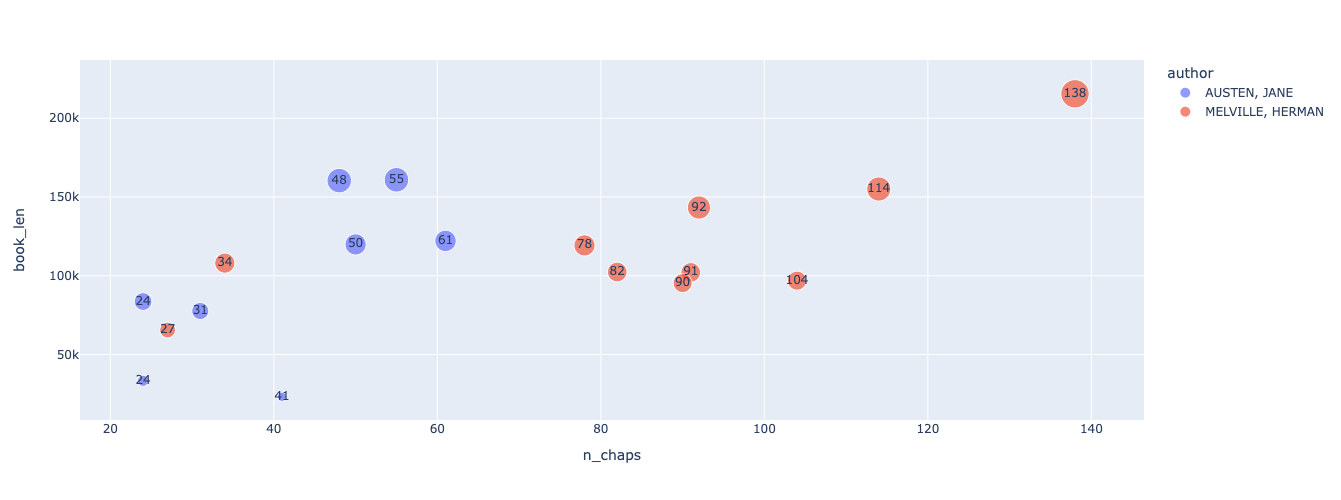

In [136]:
px.scatter(LIB, 'n_chaps', 'book_len', color='author', text='n_chaps', size='book_len', hover_name='title', width=800, height=500) 

In [133]:
LIB.groupby('author').agg('mean')

,book_len,n_chaps
author,,
"AUSTEN, JANE",97613.5,41.75
"MELVILLE, HERMAN",120328.6,85.00


# Exract VOCAB

Extract a vocabulary from the CORPUS as a whole

## Handle Anomalies

NLTK's POS tagger is not perfect -- note the classification of punctuation as nouns, verbs, etc. We remove these from our corups.

In [21]:
CORPUS[CORPUS.term_str == '']

pos_tuple  pos token_str term_str
book_id chap_id para_num sent_num token_num                                  
105     3       0        5        12         (", NNP)  NNP         "         
                         55       22         (", VBZ)  VBZ         "         
        6       0        93       0          (),, NN)   NN        ),         
        14      0        25       9          (", VBP)  VBP         "         
        20      0        22       14          (", VB)   VB         "         
...                                               ...  ...       ...      ...
34970   79      0        44       15          (&, CC)   CC         &         
        80      0        50       24         (_., NN)   NN        _.         
        83      0        44       0          (),, NN)   NN        ),         
                         45       0          ();, NN)   NN        );         
        111     0        10       3           (&, CC)   CC         &         

[468 rows x 4 columns]

In [22]:
CORPUS[CORPUS.term_str == ''].token_str.value_counts()

"        218
*        112
|         85
&          9
*****      7
),         5
+          4
'          3
?"         2
.'         2
"*         2
";         1
",         1
."         1
!"         1
_.         1
***        1
,"         1
'*         1
,'         1
....       1
::         1
_          1
'"         1
£          1
[*         1
);         1
&.         1
"...       1
'_         1
Name: token_str, dtype: int64

In [23]:
CORPUS = CORPUS[CORPUS.term_str != '']

In [24]:
VOCAB = CORPUS.term_str.value_counts().to_frame('n').sort_index()
VOCAB.index.name = 'term_str'
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['p'] = VOCAB.n / VOCAB.n.sum()
VOCAB['i'] = -np.log2(VOCAB.p)

# Annotate VOCAB

## Get Max POS

Get the most frequently associated part-of-space category for each word.

In [25]:
VOCAB['max_pos'] = CORPUS[['term_str','pos']].value_counts().unstack(fill_value=0).idxmax(1)

## Compute POS ambiguity

How many POS categories are associated with each word?

In [26]:
TPM = CORPUS[['term_str','pos']].value_counts().unstack()

In [27]:
# TPM

In [28]:
VOCAB['n_pos'] = TPM.count(1)

In [29]:
VOCAB['cat_pos'] = CORPUS[['term_str','pos']].value_counts().to_frame('n').reset_index()\
    .groupby('term_str').pos.apply(lambda x: set(x))

In [30]:
VOCAB

,n,n_chars,p,i,max_pos,n_pos,cat_pos
term_str,,,,,,,
0,2,1,1.008204e-06,19.919781,CD,1,{CD}
1,21,1,1.058614e-05,16.527464,CD,3,"{CD, JJ, NNP}"
10,6,2,3.024611e-06,18.334819,CD,1,{CD}
100,2,3,1.008204e-06,19.919781,CD,1,{CD}
1000,2,4,1.008204e-06,19.919781,CD,1,{CD}
...,...,...,...,...,...,...,...
æneas,1,5,5.041019e-07,20.919781,NNP,1,{NNP}
æniad,1,5,5.041019e-07,20.919781,NN,1,{NN}
æson,2,4,1.008204e-06,19.919781,NN,1,{NN}


In [31]:
# nltk.help.upenn_tagset()

## Add Stopwords

We use NLTK's built in stopword list for English. Note that we can add and subtract from this list, or just create our own list and keep it in our data model.

In [32]:
sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

In [46]:
# sw.sample(10)

In [34]:
VOCAB['stop'] = VOCAB.index.map(sw.dummy)
VOCAB['stop'] = VOCAB['stop'].fillna(0).astype('int')

In [35]:
VOCAB[VOCAB.stop == 1].sample(10)

,n,n_chars,p,i,max_pos,n_pos,cat_pos,stop
term_str,,,,,,,,
on,10023,2,0.005053,7.628755,IN,17,"{VBD, RBR, VBP, NN, FW, MD, JJR, VBN, NNP, RB,...",1
under,1210,5,0.000610,10.678990,IN,6,"{VBP, NN, NNP, JJ, RP, IN}",1
being,3018,5,0.001521,9.360404,VBG,10,"{VBG, VBP, NN, VBN, NNP, NNS, JJ, VBZ, VB, IN}",1
who,4425,3,0.002231,8.808320,WP,17,"{WP, VBD, VBP, NN, CD, VBN, WDT, NNP, RB, POS,...",1
just,1391,4,0.000701,10.477875,RB,8,"{NN, VBN, NNP, RB, NNS, JJ, VB, IN}",1
should,2742,6,0.001382,9.498768,MD,10,"{VBD, VBP, NN, MD, VBN, NNP, NNS, JJ, VBZ, VB}",1
what,5515,4,0.002780,8.490636,WP,20,"{FW, VBN, IN, VBP, RB, POS, NNS, WRB, WP, NN, ...",1
are,5549,3,0.002797,8.481769,VBP,16,"{VBD, VBP, NN, MD, CD, VBN, NNP, RB, NNS, JJ, ...",1
re,75,2,0.000038,14.690963,NN,9,"{VBP, NN, VBN, NNP, RB, NNS, JJ, VBZ, VB}",1


## Interlude: Stopword Stats

In [36]:
a = VOCAB.groupby('stop').n_chars.mean()
b = VOCAB.groupby('stop').n_pos.mean().sort_values(ascending=False)

In [37]:
pd.concat([a,b], 1)

,n_chars,n_pos
stop,,
0,7.867953,2.133396
1,3.766423,12.401460


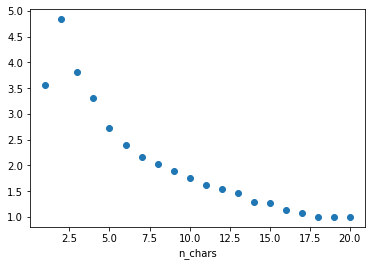

In [38]:
VOCAB.groupby('n_chars').n_pos.mean()\
    .sort_values(ascending=False).plot(style='o');

Curious that stopwords would have such variability.

In [39]:
VOCAB[VOCAB.stop == True].sort_values('n_pos', ascending=False)[['n_pos','cat_pos']].head(20)

,n_pos,cat_pos
term_str,,
you,25,"{FW, PDT, VBN, UH, PRP, IN, VBP, RB, POS, NNS,..."
now,22,"{FW, PDT, VBN, PRP, IN, VBP, RB, POS, NNS, RBR..."
me,22,"{FW, PDT, VBN, PRP, IN, VBP, RBS, RB, NNS, RBR..."
that,21,"{PDT, VBN, PRP, IN, VBG, VBP, RB, NNS, EX, WP,..."
here,21,"{PDT, VBN, PRP, IN, VBP, RB, POS, NNS, EX, WRB..."
what,20,"{FW, VBN, IN, VBP, RB, POS, NNS, WRB, WP, NN, ..."
not,20,"{FW, PDT, VBN, PRP, IN, VBP, RB, NNS, NN, JJR,..."
him,20,"{FW, PDT, VBN, PRP, IN, VBG, VBP, RB, NNS, RBR..."
there,20,"{PDT, VBN, IN, VBG, VBP, RB, POS, NNS, EX, WRB..."


Anyway . . .

## Add Stems

In [40]:
from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB['stem_porter'] = VOCAB.apply(lambda x: stemmer1.stem(x.name), 1)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB['stem_snowball'] = VOCAB.apply(lambda x: stemmer2.stem(x.name), 1)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB['stem_lancaster'] = VOCAB.apply(lambda x: stemmer3.stem(x.name), 1)

In [41]:
VOCAB.sample(10)

,n,n_chars,p,i,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,
abolitionist,3,12,1.512306e-06,19.334819,JJ,2,"{NN, JJ}",0,abolitionist,abolitionist,abolit
scibbee,1,7,5.041019e-07,20.919781,VB,1,{VB},0,scibbe,scibbe,scib
renew,9,5,4.536917e-06,17.749856,VB,1,{VB},0,renew,renew,renew
waterward,2,9,1.008204e-06,19.919781,VBP,2,"{NN, VBP}",0,waterward,waterward,waterward
fidelities,1,10,5.041019e-07,20.919781,JJ,1,{JJ},0,fidel,fidel,fidel
circumlucencies,1,15,5.041019e-07,20.919781,NN,1,{NN},0,circumluc,circumluc,circumluc
respondent,1,10,5.041019e-07,20.919781,NN,1,{NN},0,respond,respond,respond
sergeant,6,8,3.024611e-06,18.334819,NNP,2,"{NN, NNP}",0,sergeant,sergeant,serg
feather,18,7,9.073834e-06,16.749856,NN,3,"{NN, NNS, CC}",0,feather,feather,feath


In [42]:
VOCAB[VOCAB.stem_porter != VOCAB.stem_snowball]

,n,n_chars,p,i,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,
abandonedly,2,11,1.008204e-06,19.919781,RB,1,{RB},0,abandonedli,abandon,abandon
abhorringly,1,11,5.041019e-07,20.919781,RB,1,{RB},0,abhorringli,abhor,abhor
abjectly,2,8,1.008204e-06,19.919781,RB,1,{RB},0,abjectli,abject,abject
abjectus,1,8,5.041019e-07,20.919781,NNP,1,{NNP},0,abjectu,abjectus,abject
aboundingly,1,11,5.041019e-07,20.919781,RB,1,{RB},0,aboundingli,abound,abound
...,...,...,...,...,...,...,...,...,...,...,...
yes,915,3,4.612532e-04,11.082153,NN,20,"{FW, VBN, UH, PRP, IN, VBP, RB, POS, NNS, NN, ...",0,ye,yes,ye
yous,1,4,5.041019e-07,20.919781,NN,1,{NN},0,you,yous,yo
yrs,4,3,2.016408e-06,18.919781,NNP,2,"{NN, NNP}",0,yr,yrs,yr


## Save

In [43]:
out_path = f'{data_home}/output/{data_prefix}'

In [44]:
LIB.to_csv(f'{out_path}-LIB.csv')
VOCAB.to_csv(f'{out_path}-VOCAB.csv')
CORPUS.to_csv(f'{out_path}-CORPUS.csv')